In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)


# Reference scenes rendering

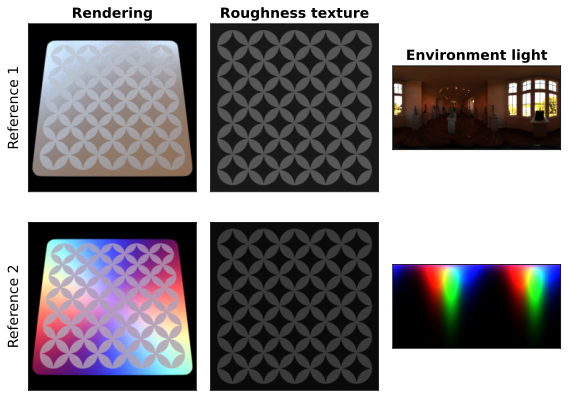

In [2]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

In [3]:
params_envlight_ref[Scene.COND1].shape

(256, 513, 4)

# Utils

In [5]:
def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Interp 1D experiments

## Scene 1

In [6]:
scene_id = Scene.COND1

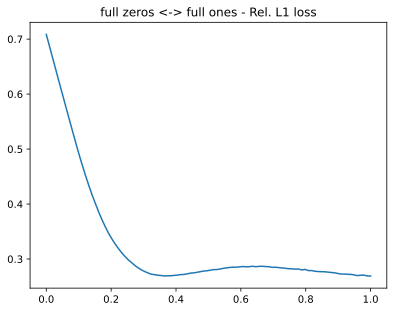

In [7]:
params_1 = get_full_zeros_params()
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="full zeros <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

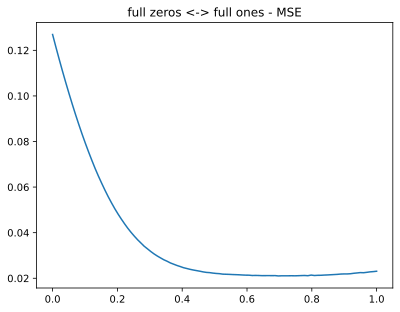

In [8]:
params_1 = get_full_zeros_params()
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="full zeros <-> full ones - MSE", loss_fn=mse)

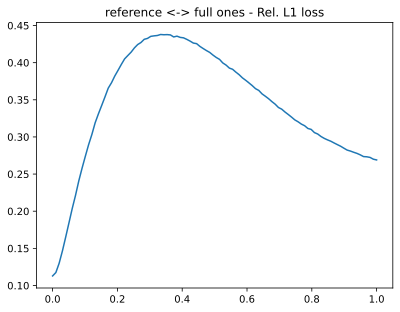

In [9]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

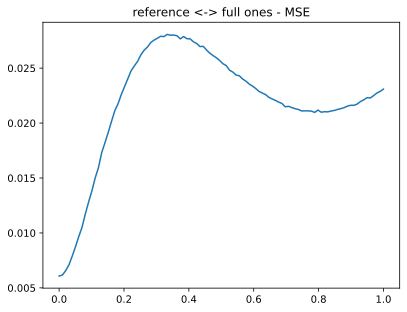

In [10]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full ones - MSE", loss_fn=mse)

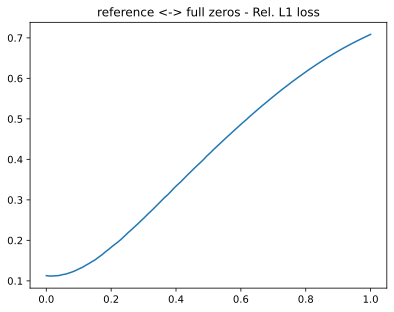

In [11]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_zeros_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full zeros - Rel. L1 loss", loss_fn=rel_l1_loss)

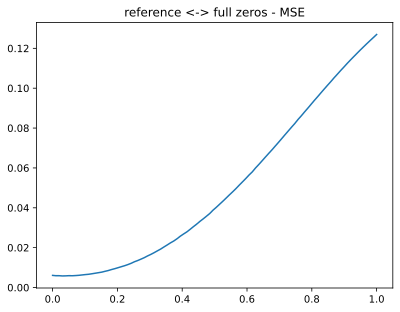

In [12]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_zeros_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full zeros - MSE", loss_fn=mse)

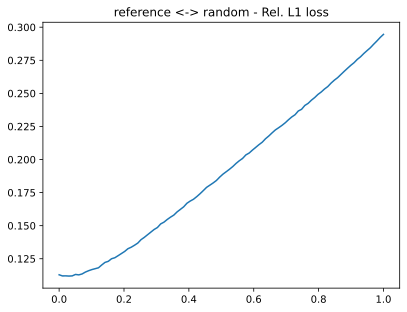

In [13]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=0)
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> random - Rel. L1 loss", loss_fn=rel_l1_loss)

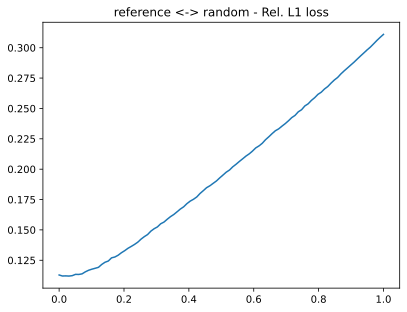

In [14]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=1)
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> random - Rel. L1 loss", loss_fn=rel_l1_loss)

## Scene 2

In [15]:
scene_id = Scene.COND2

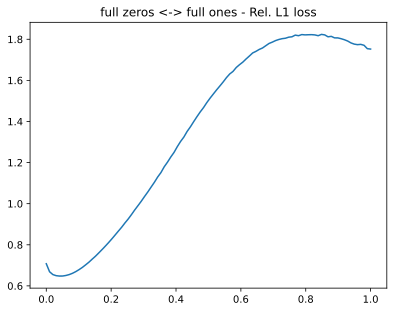

In [16]:
params_1 = get_full_zeros_params()
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="full zeros <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

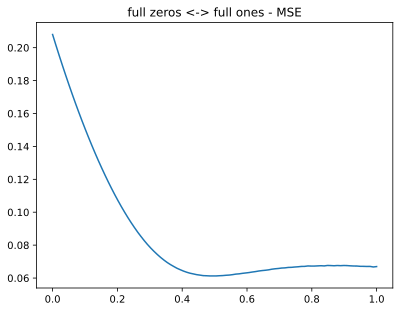

In [17]:
params_1 = get_full_zeros_params()
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="full zeros <-> full ones - MSE", loss_fn=mse)

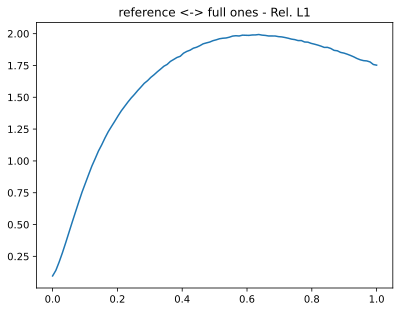

In [18]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full ones - Rel. L1", loss_fn=rel_l1_loss)

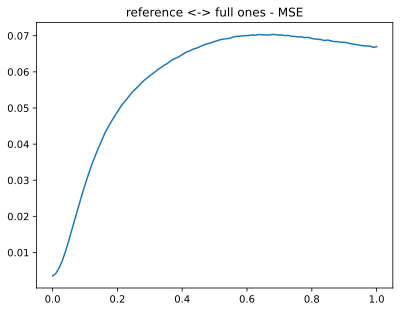

In [19]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full ones - MSE", loss_fn=mse)

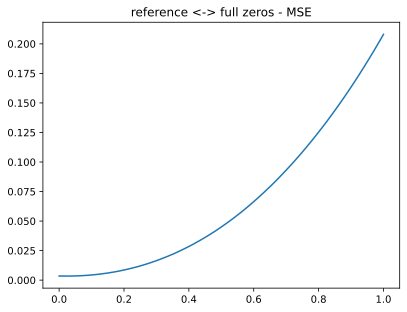

In [20]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_zeros_params()
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> full zeros - MSE", loss_fn=mse)

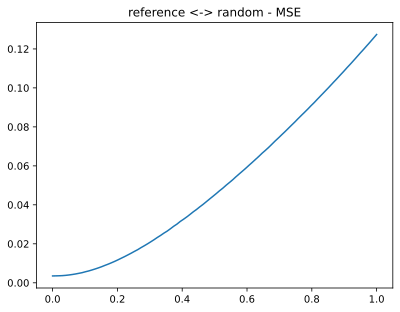

In [21]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=0)
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> random - MSE", loss_fn=mse)

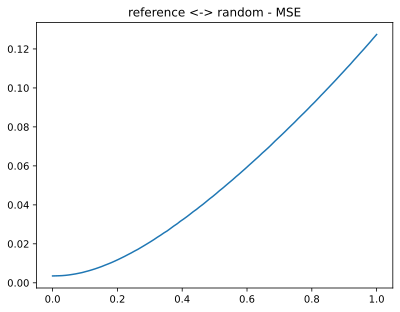

In [22]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=1)
plot_loss_linear_interp_1d(image_ref[scene_id], params_1, params_2, reset_func[scene_id], title="reference <-> random - MSE", loss_fn=mse)

# Bilinear interpolation

Scene 1

In [6]:
scene_id = Scene.COND1

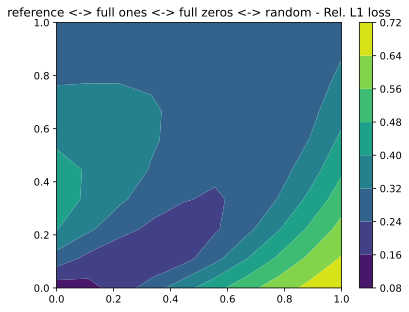

In [8]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
params_3 = get_full_zeros_params()
params_4 = generate_rand_init_values(scene_id, seed=0)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> full ones <-> full zeros <-> random - Rel. L1 loss", loss_fn=rel_l1_loss)

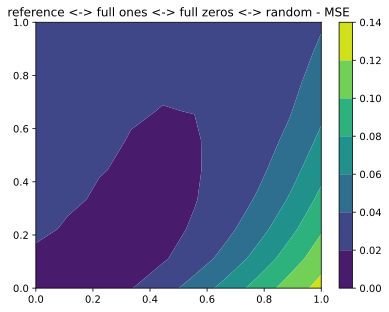

In [9]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
params_3 = get_full_zeros_params()
params_4 = generate_rand_init_values(scene_id, seed=0)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> full ones <-> full zeros <-> random - MSE", loss_fn=mse)

Scene 2

In [10]:
scene_id = Scene.COND2

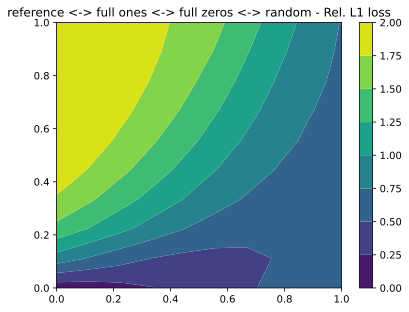

In [11]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
params_3 = get_full_zeros_params()
params_4 = generate_rand_init_values(scene_id, seed=0)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> full ones <-> full zeros <-> random - Rel. L1 loss", loss_fn=rel_l1_loss)

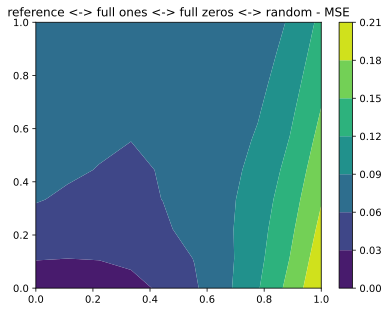

In [12]:
params_1 = get_ref_params(scene_id)
params_2 = get_full_ones_params()
params_3 = get_full_zeros_params()
params_4 = generate_rand_init_values(scene_id, seed=0)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> full ones <-> full zeros <-> random - MSE", loss_fn=mse)

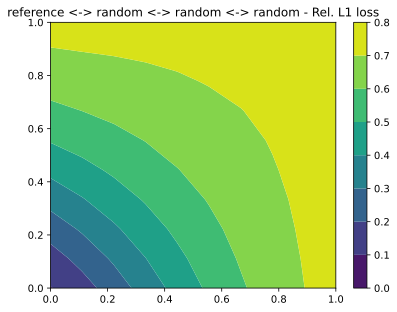

In [13]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=0)
params_3 = generate_rand_init_values(scene_id, seed=1)
params_4 = generate_rand_init_values(scene_id, seed=2)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> random <-> random <-> random - Rel. L1 loss", loss_fn=rel_l1_loss)

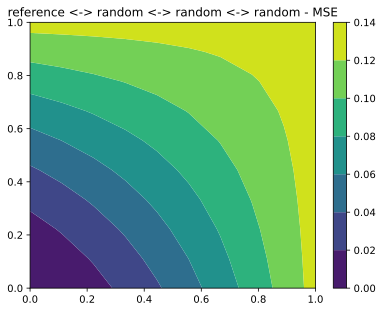

In [14]:
params_1 = get_ref_params(scene_id)
params_2 = generate_rand_init_values(scene_id, seed=0)
params_3 = generate_rand_init_values(scene_id, seed=1)
params_4 = generate_rand_init_values(scene_id, seed=2)
plot_loss_bilinear_interp_2d(image_ref[scene_id], params_1, params_2, params_3, params_4, reset_func[scene_id], title="reference <-> random <-> random <-> random - MSE", loss_fn=mse)